# Logistic regression showdown

In [1]:
import re
import jax
import optax
import distrax
import pandas as pd
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp

from time import time
from functools import partial 
from jax.flatten_util import ravel_pytree
from rebayes.utils import utils
from rebayes.datasets import datasets
from rebayes.low_rank_filter import lofi
from rebayes.low_rank_filter import lrvga
from rebayes.extended_kalman_filter import ekf
from rebayes.sgd_filter import replay_sgd

tfd = tfp.distributions

In [2]:
from scipy.io import arff
import pandas as pd

# regexp = re.compile("[0-9] (-?[0-9]+\.[0-9]+|-?[0-9]+)")
regexp = re.compile("(?P<ix>[0-9]) (?P<val>-?[0-9]+\.[0-9]+|-?[0-9]+)")
file = "../data/classification/php89ntbG.arff"

rows = []
n_rows = 0

n_cols = 0
base_row = {n: 0.0 for n in range(n_cols)}

with open(file, "r") as f:
    for line in f.readlines():
        row = regexp.findall(line)
        n_rows += 1
        if len(row) > 0:
            row = jax.tree_map(float, row)
            row = {int(match.group("ix")): float(match.group("val")) for match in regexp.finditer(line)}
            row = {**base_row, **row}
            
            rows.append(row)

In [ ]:
rows = pd.DataFrame(rows)
rows = rows.sample(frac=1.0, random_state=314, replace=False)
rows = jnp.array(rows.to_numpy())
rows[:10]

In [4]:
frac_test = 0.3
n_test = round(n_rows * frac_test)

train = rows[:-n_test]
test = rows[-n_test:]

X_train = train[:, 1:]
y_train = (train[:, 0] + 1) / 2

X_test = test[:, 1:]
y_test = (test[:, 0] + 1) / 2

_, num_features = X_train.shape

In [5]:
X_train = X_train.at[jnp.isnan(X_train)].set(0.0)
X_test = X_test.at[jnp.isnan(X_test)].set(0.0)

In [6]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 1.5

In [7]:
key = jax.random.PRNGKey(314)
key_train, key_test, key_model = jax.random.split(key, 3)

In [3]:
num_train = 1_000
num_test = 1_000
num_features = 250

dgenerator = datasets.LRDataset(
    dim_inputs=num_features,
    sigma=1.0,
    scale=5.0,
    condition_number=0.01# 0.05
)



gstate, (X_train, y_train) = dgenerator.sample_train(key_train, num_train)
X_test, y_test = dgenerator.sample_test(key_test, gstate, 1_000)

y_train = jax.nn.sigmoid(y_train)
y_test = jax.nn.sigmoid(y_test)

sns.histplot(y_train, bins=50)

In [8]:
class LogReg(nn.Module):
    n_out: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_out)(x)
        return x

In [9]:
model = LogReg(1)
params_init = model.init(key_model, X_train)
params_init, rfn = ravel_pytree(params_init)

# Start with belief state 0
params_init = params_init * 0.0

In [10]:
def meanfn(w, x):
    log_mu = model.apply(rfn(w), x)
    mu = jax.nn.sigmoid(log_mu)
    return mu

def covfn(w, x):
    mu = meanfn(w, x)
    return mu * (1 - mu)

In [11]:
def get_acc(X, y, w):
    yhat = meanfn(w, X).ravel() > 0.5
    acc = (y > 0.5) == yhat
    return acc.mean()


def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):
    
    acc_train = get_acc(X_train, y_train, bel.mean)
    acc_test = get_acc(X_test, y_test, bel.mean)
    
    metric = {
        "train": 1 - acc_train,
        "test": 1 - acc_test
    }
    
    return metric

In [93]:
memory_sizes = [1, 20, 30, 50, 70, 100]
memory_sizes = [1, 2, 5, 8]

In [94]:
# Base params for EKF and LoFi
base_params = {
    "dynamics_covariance": 1e-5, # 1e-7
    "emission_mean_function": meanfn,
    "emission_cov_function": covfn,
    "emission_dist": lambda mean, cov: tfd.Bernoulli(loc=mean),
}


In [95]:
initial_covariance = 5e-3
dweights=0.9999

In [96]:
%%time
res_lofi = {}
for memory in memory_sizes:
    agent = lofi.RebayesLoFiDiagonal(
        dynamics_weights=dweights,
        **base_params,
        memory_size=memory
    )
    
    time_init = time()
    bel, hist = agent.scan(
        params_init, initial_covariance, X_train, y_train > 0.5, progress_bar=True, callback=callback
    )
    time_end = time()
    
    hist["time"] = time_end - time_init
    res_lofi[memory] = hist

res_lofi = jax.tree_map(np.array, res_lofi)

  0%|          | 0/341989 [00:00<?, ?it/s]

  0%|          | 0/341989 [00:00<?, ?it/s]

  0%|          | 0/341989 [00:00<?, ?it/s]

  0%|          | 0/341989 [00:00<?, ?it/s]

CPU times: user 20.4 s, sys: 1.07 s, total: 21.5 s
Wall time: 18min 20s


CPU times: user 99.5 ms, sys: 7.69 ms, total: 107 ms
Wall time: 83.9 ms


<AxesSubplot: xlabel='num. observations'>

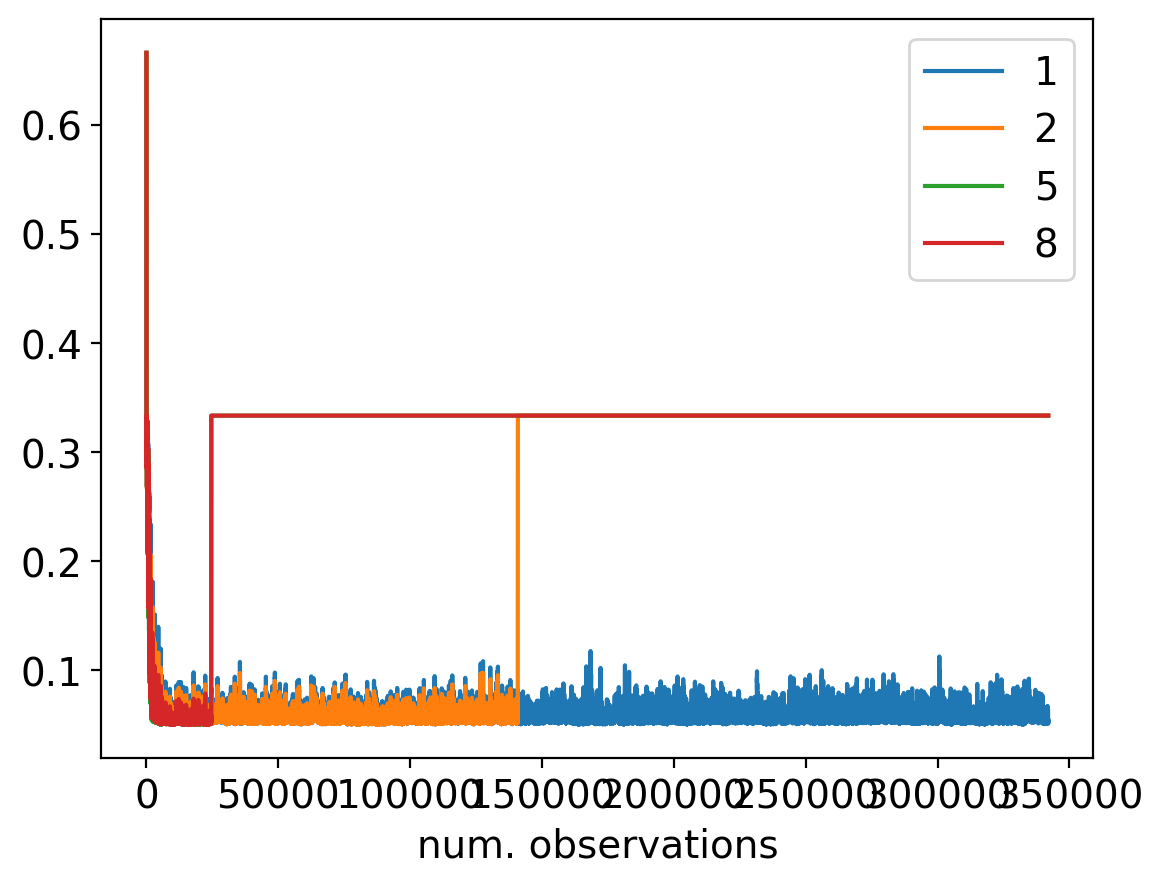

In [97]:
%%time
res_lofi_df = pd.DataFrame(utils.get_subtree(res_lofi, "test"))
res_lofi_df.index.name = "num. observations"

res_lofi_df.plot()

## L-RVGA

In [ ]:
def fwd_link(w, bel, x):
    log_mu = model.apply(rfn(w), x)
    mu = jax.nn.sigmoid(log_mu)
    return mu, mu * (1 - mu)


def log_prob(mean, bel, x, y):
    mu, _ = fwd_link(mean, bel, x)
    
    logp = distrax.Bernoulli(mu).log_prob(y).sum()
    return logp

In [ ]:
res_lrvga = {}

hparams = {
    "sigma2": 1.0,
    "eps": 1e-3, # 1e-3
    "std": 1.0,
}

for memory in memory_sizes:
    agent = lrvga.LRVGA(
        fwd_link=fwd_link,
        log_prob=log_prob,
        n_samples=20,
        n_inner=5,
        n_outer=5
    )
    
    time_init = time()
    bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_train, memory, **hparams)
    bel_init.replace(mu=bel_init.mu * 0.0)
    
    bel, hist = agent.scan(
        bel_init, initial_covariance, X_train, y_train > 0.5, progress_bar=True, callback=callback,
        bel=bel_init,
    )
    time_end = time()
    
    hist["time"] = time_end - time_init
    
    res_lrvga[memory] = hist
res_lrvga = jax.tree_map(np.array, res_lrvga)

In [ ]:
res_lrvga_df = pd.DataFrame(utils.get_subtree(res_lrvga, "test"))
res_lrvga_df.index.name = "num. observations"

In [ ]:
vmin = res_lrvga_df.quantile(0.001).min()
vmax = res_lrvga_df.quantile(0.995).max()

res_lrvga_df.plot()
plt.ylim(vmin, vmax)

In [ ]:
def xentropy(y, yhat):
    loss = y * jnp.log(yhat) + (1 - y) * jnp.log(1 - yhat)
    return -loss.mean()

In [ ]:
def get_acc(X, y, w):
    yhat = jax.nn.sigmoid(model.apply(w, X).ravel()) > 0.5
    acc = (y > 0.5) == yhat
    return acc.mean()


@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_xentropy(params, counter, X, y, apply_fn):
    """
    Loss function for one-hot encoded classification
    problems.
    """
    yhat = apply_fn(params, X)
    yhat = jax.nn.sigmoid(yhat).squeeze()
    
    y = y.squeeze()
    
    loss = - (y * jnp.log(yhat) + (1 - y) * jnp.log(1 - yhat)) * counter
    loss = loss.sum() / counter.sum()

    # logits = jnp.log(yhat) # B x K
    # loss = -jnp.einsum("b...,b...,b->", logits, y, counter) / counter.sum()
    return loss

In [ ]:
res_rsgd = {}
bel_init = model.init(key, X_train)

tx = optax.adam(1e-3)
tx = optax.adam(1e-5)

for memory in memory_sizes:
    agent = replay_sgd.FifoSGD(
        lossfn_xentropy,
        model.apply,
        tx,
        memory,
        num_features,
        dim_output=1
    )

    time_init = time()
    bel, hist = agent.scan(
        bel_init, 5e-3, X_train, y_train, progress_bar=True, callback=callback
    )
    time_end = time()
    
    hist["time"] = time_end - time_init
    
    res_rsgd[memory] = hist
res_rsgd = jax.tree_map(np.array, res_rsgd)

In [ ]:
res_rsgd_df = pd.DataFrame(utils.get_subtree(res_rsgd, "test"))
res_rsgd_df.index.name = "num. observations"

res_rsgd_df.plot()
plt.xticks(rotation=45);

## FCEKF

In [ ]:
initial_covariance = 1e-6
initial_covariance

In [ ]:
base_params

In [ ]:
ekf_params = {**base_params, "dynamics_covariance": 1e-7}

In [ ]:
def get_acc(X, y, w):
    yhat = meanfn(w, X).ravel() > 0.5
    acc = (y > 0.5) == yhat
    return acc.mean()


agent = ekf.RebayesEKF(
    1.,
    **ekf_params,
)

bel, res_ekf = agent.scan(
    params_init, initial_covariance, X_train, y_train, progress_bar=True, callback=callback
)


In [ ]:
res_ekf_df = pd.DataFrame({"full": np.array(res_ekf["train"])})
res_ekf_df.index.name = "num. observations"
res_ekf_df.plot()

## Showdown!

<AxesSubplot: xlabel='num. observations'>

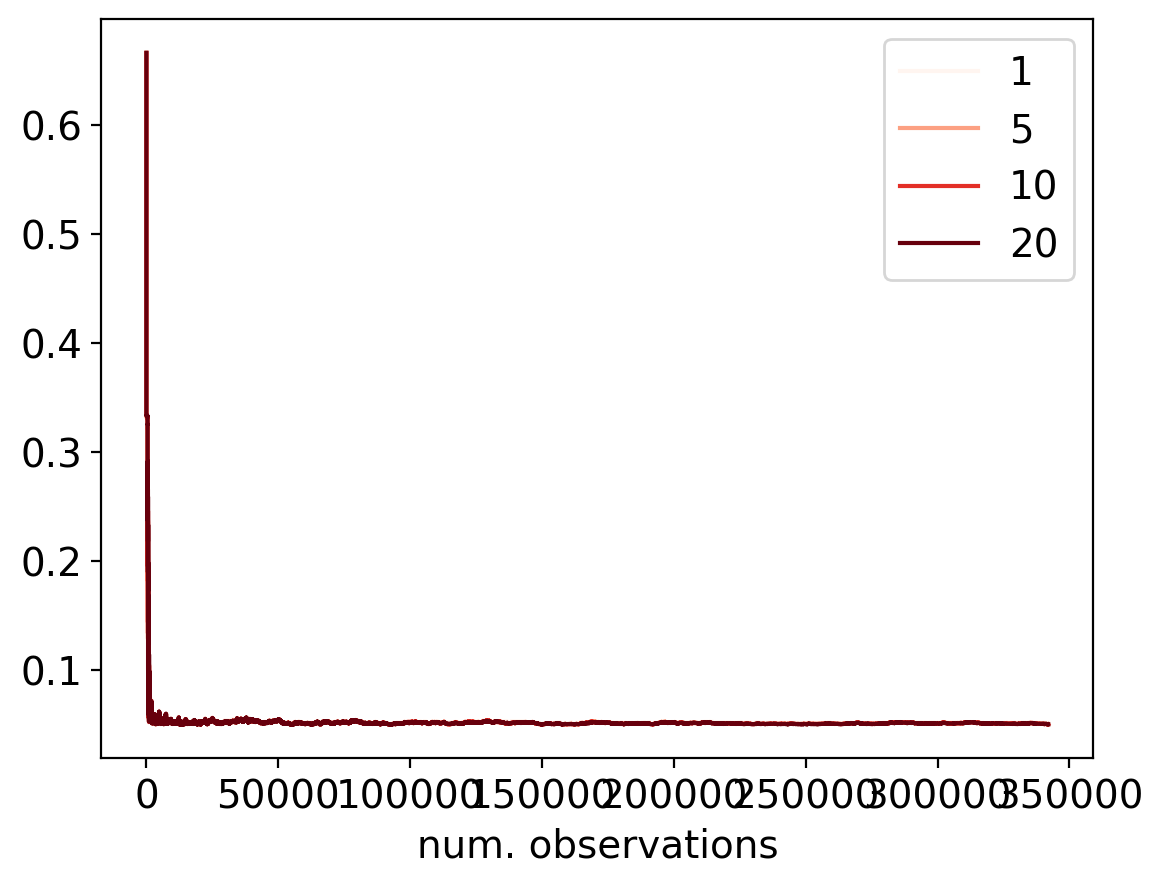

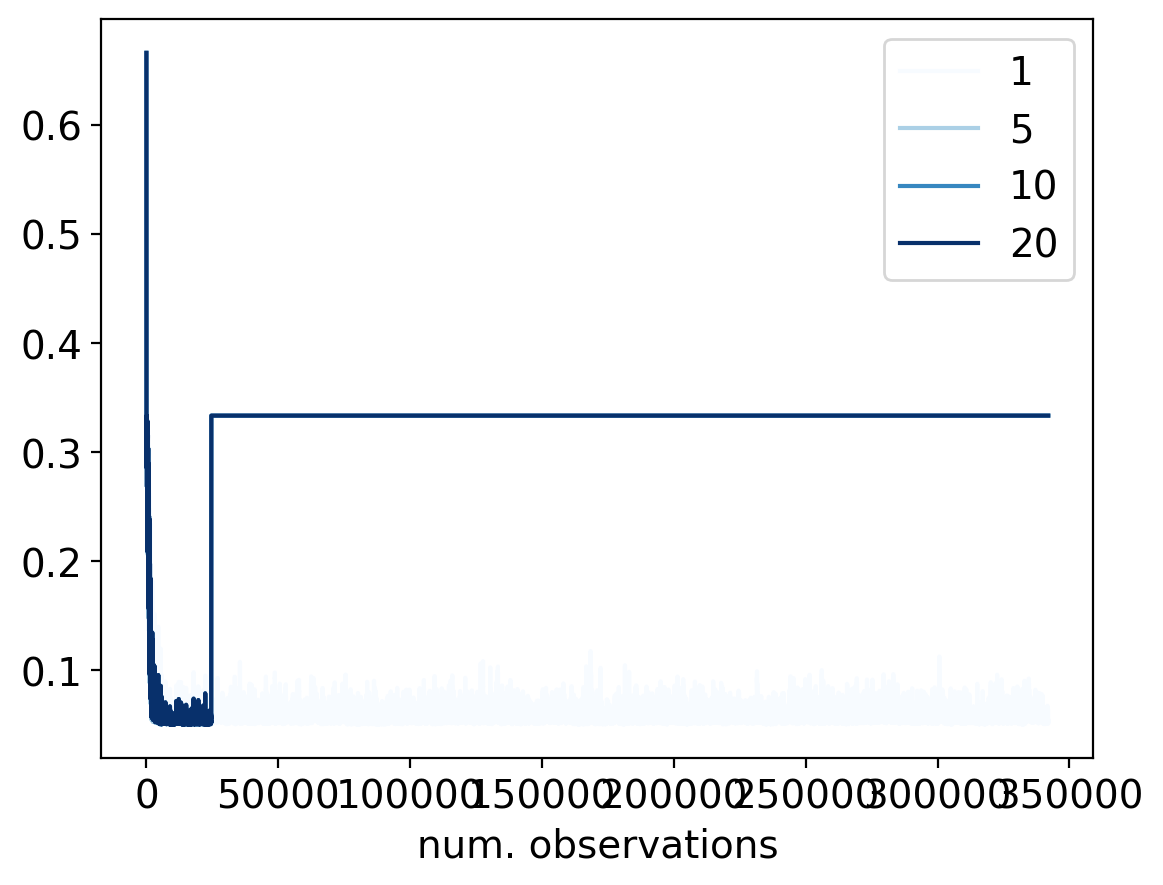

In [91]:
fig, ax = plt.subplots()
res_lrvga_df.plot(cmap="Reds", ax=ax)
res_lofi_df.plot(cmap="Blues", ax=ax)

(0.049592018127441406, 0.2)

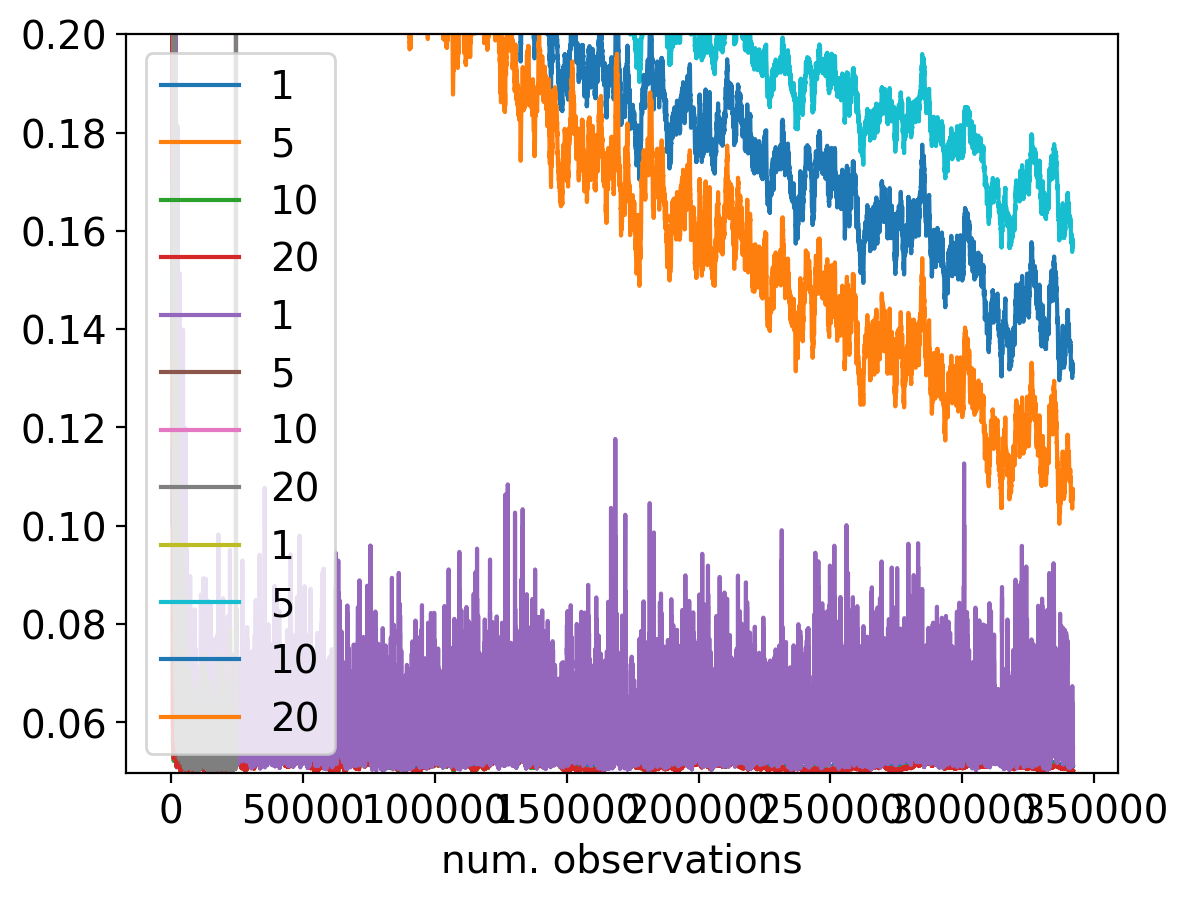

In [81]:
fig, ax = plt.subplots()

res_lrvga_df.plot(ax=ax)
res_lofi_df.plot(ax=ax)
res_rsgd_df.plot(ax=ax)


vmin = res_lrvga_df.min()
vmax = res_lrvga_df.quantile(0.995).max()
ax.set_ylim(vmin, 0.2)

KeyboardInterrupt: 

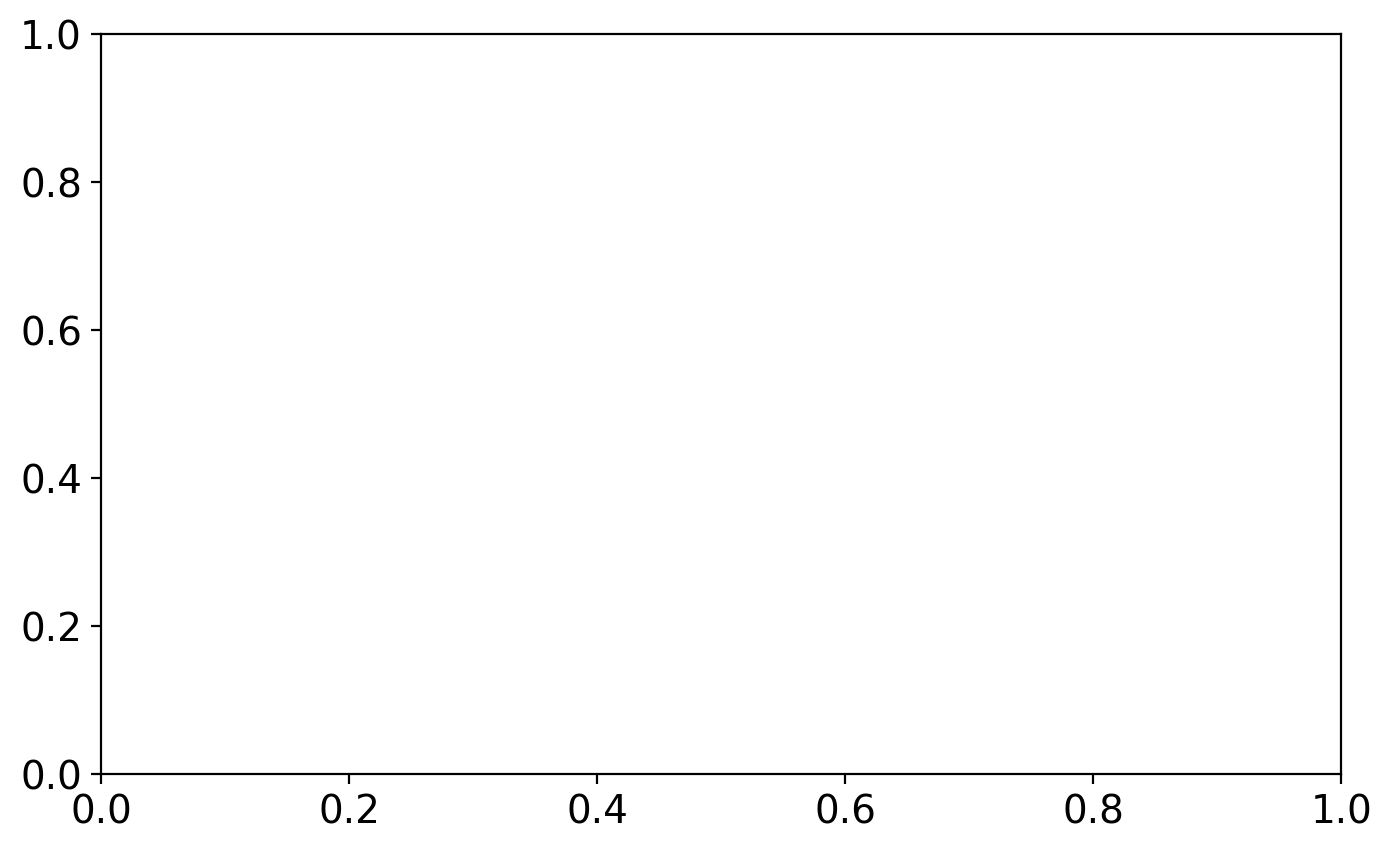

In [73]:
fig, ax = plt.subplots(figsize=(8, 4.8))

sns.lineplot(
    x="num. observations",
    y="value",
    style="memory",
    hue="method",
    data=res_melt,
    n_boot=1
)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("missclassification rate")
plt.tight_layout()
plt.grid(alpha=0.3)

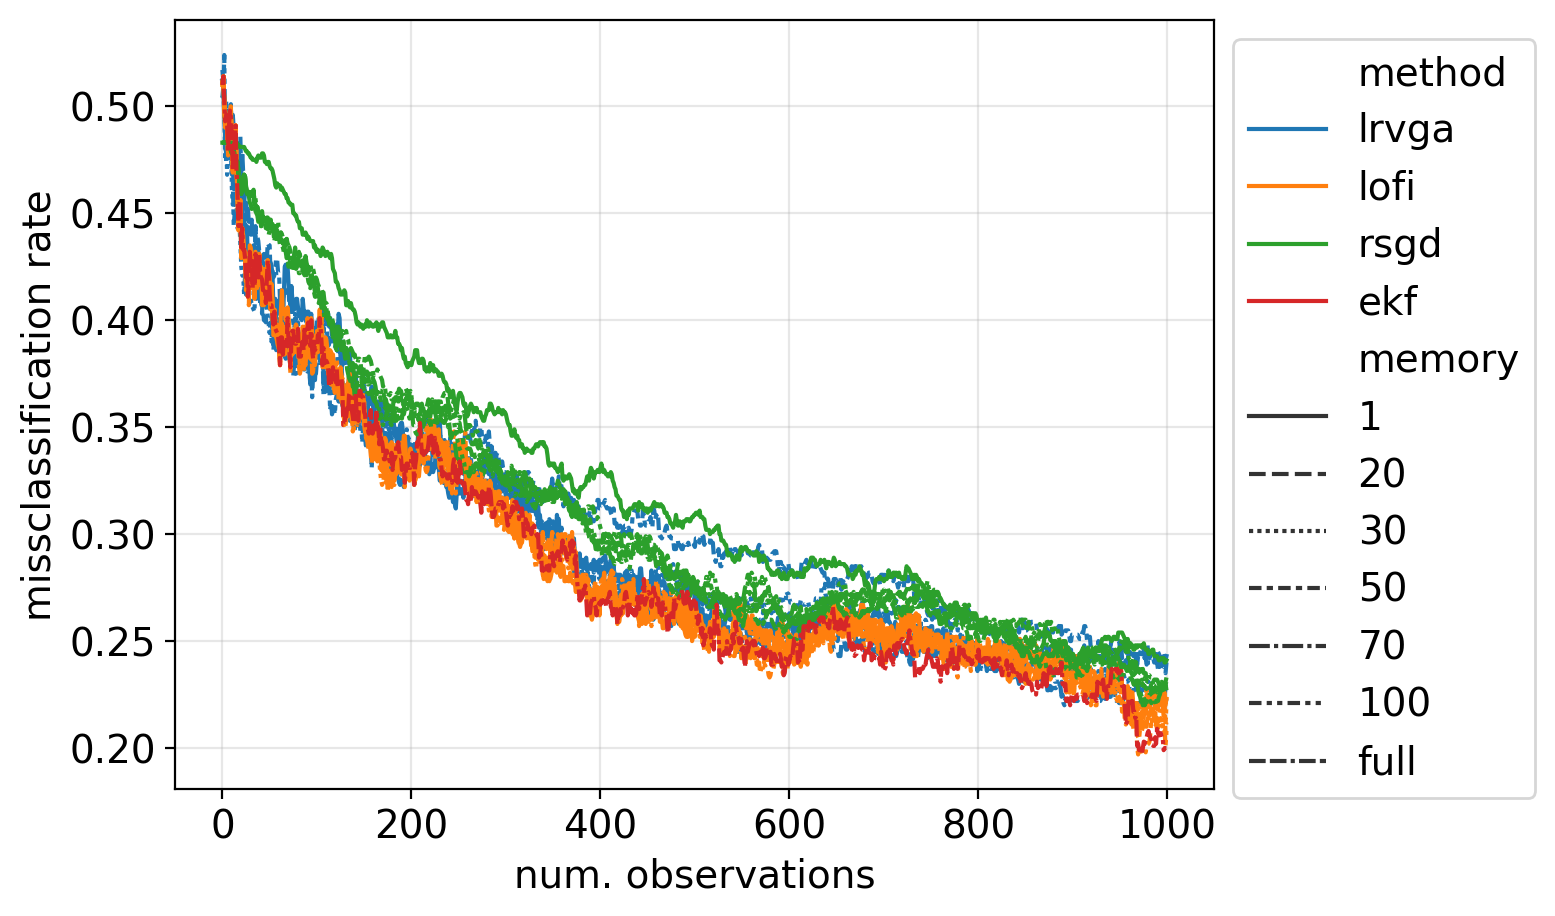

In [82]:
fig, ax = plt.subplots(figsize=(8, 4.8))

sns.lineplot(
    x="num. observations",
    y="value",
    style="memory",
    hue="method",
    data=res_melt,
)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("missclassification rate")
plt.tight_layout()
plt.grid(alpha=0.3)

Text(0, 0.5, 'missclassification rate')

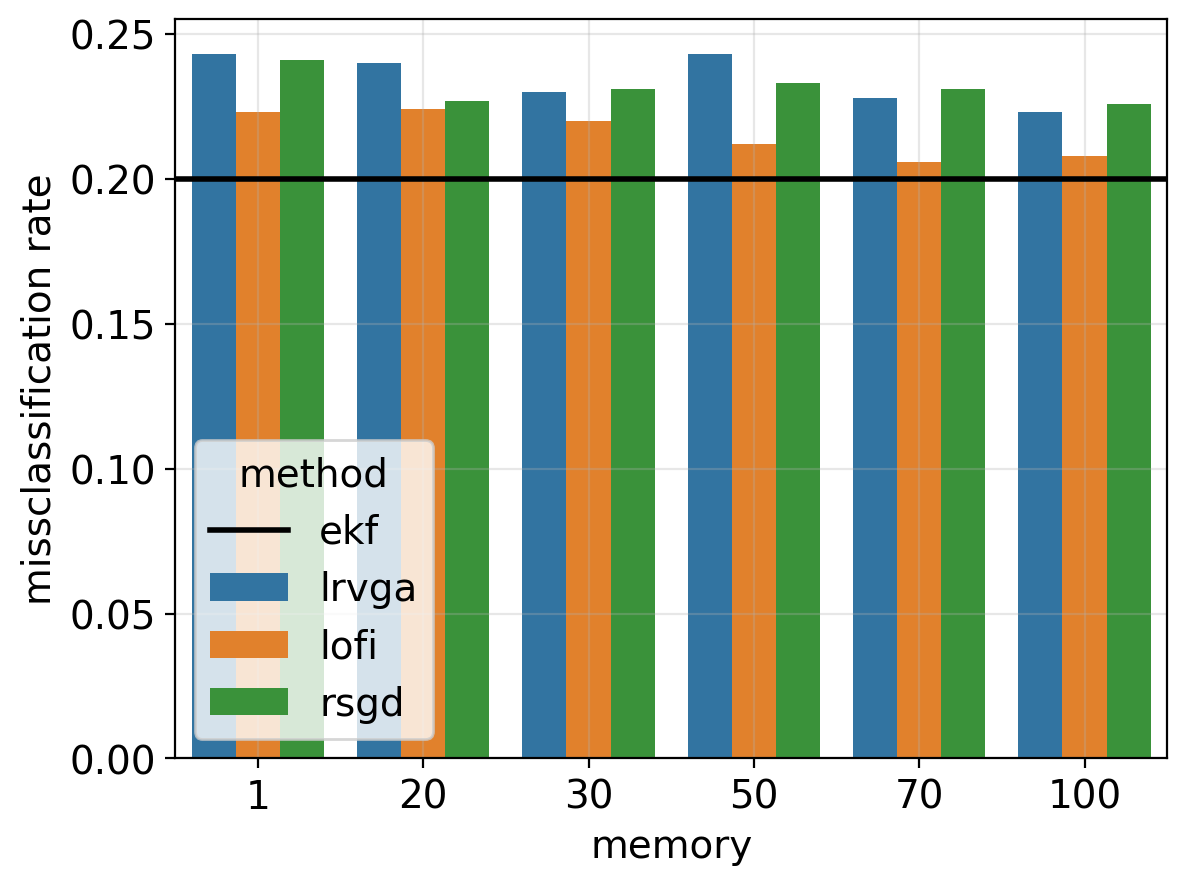

In [84]:
ekf_final = res_melt[res_melt["num. observations"] == num_train -1].query("method == 'ekf'")["value"].item()

fig, ax = plt.subplots()

plt.axhline(y=ekf_final, c="black", linewidth=2, label="ekf")
sns.barplot(
    y="value",
    x="memory",
    hue="method",
    data=res_melt[res_melt["num. observations"] == num_train-1].query("method != 'ekf'"),
)



plt.grid(alpha=0.3)
plt.ylabel("missclassification rate")

## Time analysis

In [85]:
res_time = pd.DataFrame([
    pd.Series(utils.get_subtree(res_lofi, "time"), name="lofi"),
    pd.Series(utils.get_subtree(res_lrvga, "time"), name="lrvga"),
    pd.Series(utils.get_subtree(res_rsgd, "time"), name="rsgd")
]).T

res_time = res_time.astype(float)

<AxesSubplot: >

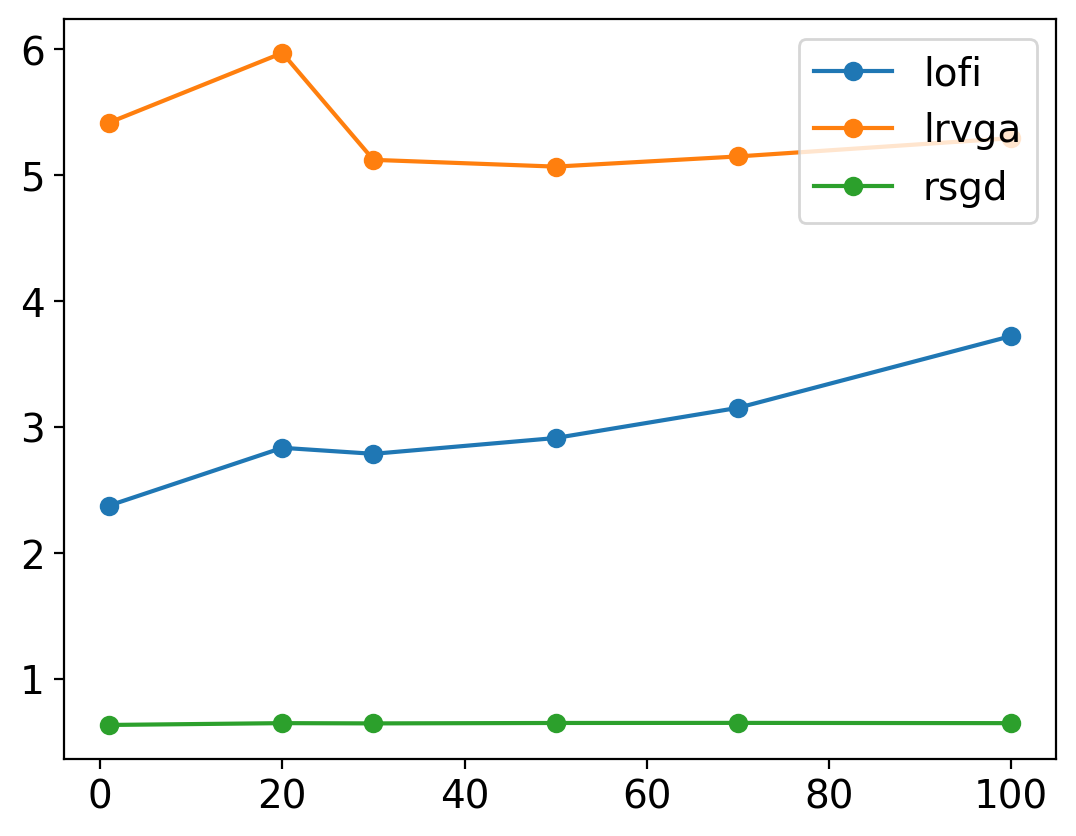

In [86]:
res_time.plot(marker="o")